In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn import tree

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
 !ls data/main_dataset

Variable_Codebook.docx data.csv               data_target.csv


In [26]:
dfX = pd.read_csv('data/main_dataset/data.csv')
dfy = pd.read_csv('data/main_dataset/data_target.csv', index_col=0, names=['target'])

In [27]:
geoX = gp.GeoDataFrame(X.copy(), geometry=gp.points_from_xy(X.Longitude, X.Latitude))

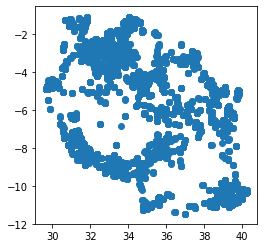

In [28]:
geoX.plot(column='');

In [78]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,Q8_8,Q8_9,Q8_10,Q8_11,Q12,Q13,Q14,Q15,Q18,Q19,Latitude,Longitude
Unnamed: 0,1,0.0109148,-0.00346926,0.00242909,0.00636901,-0.0173017,-0.0072194,-0.00469392,0.0115803,0.00947531,-0.00329371,-0.00487488,0.00429784,-0.0100247,-0.00687631,-0.0121286,-0.00398274,0.00690762,-0.00456481,0.00791813,-0.00652252,-0.0112945,0.00838114,-0.00185249,-0.00826271,0.027939,-0.0138131
Q1,0.0109148,1,-0.0585939,-0.16052,-0.330511,-0.363687,-0.0982437,0.083468,-0.0628313,0.132521,-0.045227,-0.10246,0.0667396,-0.00853564,0.112912,0.177581,0.0220983,-0.0797765,-0.00117296,0.135896,-0.13085,0.0261936,-0.0150986,0.276873,0.20658,-0.0360456,0.0332666
Q2,-0.00346926,-0.0585939,1,0.0107767,-0.117028,0.110447,0.111766,0.18161,-0.0833304,-0.0822862,-0.0217417,-0.120857,-0.0246791,0.0267471,-0.035117,0.0638825,0.222555,0.122975,0.00457531,0.143126,-0.13031,0.0497913,-0.0560385,0.139769,0.131395,0.0117197,-0.00141751
Q3,0.00242909,-0.16052,0.0107767,1,0.152124,0.178123,0.108667,0.0303524,0.0509326,-0.232675,-0.000125958,-0.0036042,-0.0244357,-0.0117246,-0.0288144,0.0394275,0.08088,0.108755,-0.00874099,0.020261,-0.0236353,-0.0297027,0.0191125,-0.020489,-0.156452,0.0147182,0.0598536
Q4,0.00636901,-0.330511,-0.117028,0.152124,1,0.235854,-0.0658447,-0.308913,0.314422,-0.203489,0.0655877,-0.0612477,0.0132201,0.00978692,0.0899312,-0.109296,0.020842,0.0407321,0.00737698,-0.322591,0.278984,-0.223603,0.182029,-0.564634,-0.629311,0.034254,0.123074
Q5,-0.0173017,-0.363687,0.110447,0.178123,0.235854,1,0.0615836,-0.0726938,0.152766,-0.245222,0.0336651,0.0106185,-0.0626905,0.00776189,-0.0393032,-0.0633188,0.0803243,0.100095,-0.0067631,-0.115792,0.0938451,-0.0500205,0.0280831,-0.109384,-0.159148,0.0818988,0.030335
Q6,-0.0072194,-0.0982437,0.111766,0.108667,-0.0658447,0.0615836,1,0.109005,-0.0803714,-0.0218564,-0.0111175,0.0242613,-0.0307271,0.00395025,-0.0473901,0.0481746,0.0928315,0.0602141,-0.0206554,0.107182,-0.0873872,0.0462339,-0.0346768,0.0575946,0.0587422,0.00500253,-0.0163751
Q7,-0.00469392,0.083468,0.18161,0.0303524,-0.308913,-0.0726938,0.109005,1,-0.180784,0.0213092,-0.108965,0.0313331,-0.0381813,-0.0122918,-0.0484952,0.0847186,0.0634836,0.0948667,-0.0286806,0.395526,-0.360163,0.352266,-0.301268,0.322242,0.250234,-0.0340211,-0.137683
Q8_1,0.0115803,-0.0628313,-0.0833304,0.0509326,0.314422,0.152766,-0.0803714,-0.180784,1,-0.208442,-0.0367618,-0.140367,0.0143092,0.0212129,-0.00889978,-0.0356112,-0.0705924,-0.0638938,-0.00900116,-0.227666,0.177577,-0.0793299,0.0627192,-0.12204,-0.256071,0.00708961,0.0832292
Q8_2,0.00947531,0.132521,-0.0822862,-0.232675,-0.203489,-0.245222,-0.0218564,0.0213092,-0.208442,1,-0.125744,-0.123339,0.00277135,0.0176361,-0.0374064,-0.00158987,-0.19893,-0.326227,-0.0368614,0.0284412,-0.0180087,0.0146076,0.00309692,0.0370948,0.151231,-0.0727571,-0.137712


# classification_ranf

In [32]:
X = dfX #.values
y = dfy.values.flatten()

In [33]:
X_learn, X_test, y_learn, y_test = train_test_split(X, y, stratify=yy, test_size=0.25)

In [34]:
# A good rule of thumb when tuning the max_features parameter of the hyperparameter
# algorithm is to set it equal to the squareroot of the total number of features. As
# such, during tuning the hyperparameter is varied from about 30% less than this rule
# of thumb value, to about 30% above it.
min_features = round((len(X.columns) ** 0.5) * 0.7)
max_features = round((len(X.columns) ** 0.5) * 1.3)

parameters = {'n_estimators': [100, 300, 400], #number of trees in the forest
              'max_features': [i for i in range(min_features, max_features, 1)],
              'criterion': ['gini', 'entropy']} #metric according to which purity of split is determined

model = RandomForestClassifier()

classes = list(set(y))

In [35]:
if len(classes) > 2:  #determine whether the task is a binary or multilabel classification task
    for k in list(parameters.keys()):
        parameters['estimator__' + k] = parameters.pop(k)   #the onevsallclassifier wants the parameters to be preceeded by the label 'esitimator__'
    model = OneVsRestClassifier(model)
    y_learn = label_binarize(y_learn, classes=classes)  #label_binarize is similar to onehotencoding
    y_test = label_binarize(y_test, classes=classes)

In [36]:
grid_search = GridSearchCV(model, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1,
                           return_train_score=True)

In [37]:
best_model = grid_search.fit(X_learn, y_learn)  #using gridsearch to tune hyperparameters

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 12.4min finished


In [38]:
print('best parameters:', best_model.best_params_)
print('performance on training data:', best_model.best_score_)
y_pred = best_model.predict(X_test)
print('performance on test data:', roc_auc_score(y_test, y_pred))

best parameters: {'estimator__criterion': 'entropy', 'estimator__max_features': 6, 'estimator__n_estimators': 400}
performance on training data: 0.8291048186980428
performance on test data: 0.6568403756052192


In [39]:
# investigating the extent to which each feature contributed to the prediction task
model = RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=400)
best_model = model.fit(X_learn, y_learn)
y_pred = best_model.predict(X_test)
print('performance on test data:', roc_auc_score(y_test, y_pred))
tat = best_model.feature_importances_

performance on test data: 0.6528403095824649


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


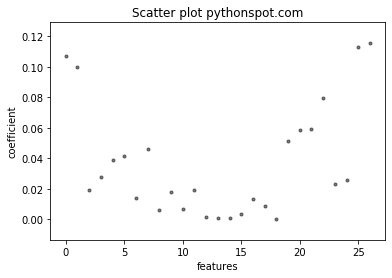

In [40]:
# visualising vector coefficients
colors = (0, 0, 0)
area = np.pi * 3
headings = np.arange(len(X.columns))
plt.scatter(headings, tat, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('features')
plt.ylabel('coefficient')
plt.show()

# classification_decistree

In [41]:
X_learn, X_test, y_learn, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [66]:
parameters = {'criterion': ['gini', 'entropy'],
              'min_samples_leaf': list(range(1, 500, 1))}

In [67]:
model = DecisionTreeClassifier()

In [68]:
classes = list(set(y))

In [69]:
if len(classes) > 2:
    for k in list(parameters.keys()):
        parameters['estimator__' + k] = parameters.pop(k)
    model = OneVsRestClassifier(model)
    y_learn = label_binarize(y_learn, classes=classes)
    y_test = label_binarize(y_test, classes=classes)

In [70]:
grid_search = GridSearchCV(model, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1,
                           return_train_score=True)

In [71]:
best_model = grid_search.fit(X_learn, y_learn)

Fitting 10 folds for each of 998 candidates, totalling 9980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5592 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7692 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9973 out of 9980 | elapsed:  6.3min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 9980 out of 9980 | elapsed:  6.3min finished


In [72]:
print('best parameters:', best_model.best_params_)
print('performance on training data:', best_model.best_score_)
y_pred = best_model.predict(X_test)
print('performance on test data:', roc_auc_score(y_test, y_pred))

best parameters: {'estimator__criterion': 'gini', 'estimator__min_samples_leaf': 85}
performance on training data: 0.8244585628108224
performance on test data: 0.6477393213323958


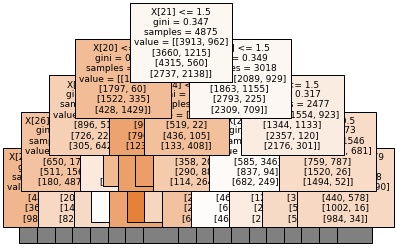

In [73]:
criterion = best_model.best_params_['estimator__criterion']
min_samples_leaf = best_model.best_params_['estimator__min_samples_leaf']
model = DecisionTreeClassifier(criterion=criterion, min_samples_leaf=min_samples_leaf)
best_model_ = model.fit(X_learn, y_learn)
plot_tree(best_model_, max_depth=4, filled=True, fontsize= 9)
plt.show()

# XGboost

In [82]:
X_learn, X_test, y_learn, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
#y_learn = label_binarize(y_learn, classes=classes)
#y_test = label_binarize(y_test, classes=classes)

In [88]:
param_dist = {'objective':'binary:logistic', 'n_estimators':2, 'eval_metric': "mlogloss"}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_learn, y_learn,
        eval_set=[(X_learn, y_learn), (X_test, y_test)],
        eval_metric='logloss',
        verbose=True)

evals_result = clf.evals_result()

XGBoostError: [12:00:58] src/metric/elementwise_metric.cu:326: Check failed: preds.Size() == info.labels_.Size() (19500 vs. 4875) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000120a4e319 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x0000000120abd908 xgboost::metric::EvalEWiseBase<xgboost::metric::EvalRowLogLoss>::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, bool) + 568
  [bt] (2) 3   libxgboost.dylib                    0x0000000120a4b25f xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<xgboost::DMatrix*, std::__1::allocator<xgboost::DMatrix*> > const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > const&) + 1487
  [bt] (3) 4   libxgboost.dylib                    0x0000000120a697cd XGBoosterEvalOneIter + 909
  [bt] (4) 5   _ctypes.cpython-37m-darwin.so       0x00000001054f73a7 ffi_call_unix64 + 79
  [bt] (5) 6   ???                                 0x00007ffeec6db970 0x0 + 140732865034608

